---
title: Gradient Considerations
date: 2023-04-01
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: NerFs, Images
---

In [1]:
import sys, os

# spyder up to find the root
oceanbench_root = "/gpfswork/rech/cli/uvo53rl/projects/oceanbench"

# append to path
sys.path.append(str(oceanbench_root))

In [2]:
import autoroot
import typing as tp
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import numpy as np
import numba as nb
import pandas as pd
import equinox as eqx
import kernex as kex
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from omegaconf import OmegaConf
import hydra
import metpy
from sklearn.pipeline import Pipeline


sns.reset_defaults()
sns.set_context(context="poster", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Processing Chain

**Part I**:

* Open Dataset
* Validate Coordinates + Variables
* Decode Time
* Select Region
* Sortby Time

**Part II**: Regrid

**Part III**:

* Interpolate Nans
* Add Units
* Spatial Rescale
* Time Rescale

**Part IV**: Metrics

*

## Data

In [3]:
# !wget wget -nc https://s3.us-east-1.wasabisys.com/melody/osse_data/ref/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc

In [4]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS

2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc	     ssh_DUACS_swot_4nadir.nc
2020a_SSH_mapping_NATL60_DUACS_swot_en_j1_tpn_g2.nc  ssh_DUACS_swot.nc
ssh_DUACS_4nadir.nc


In [5]:
# !cat configs/postprocess.yaml

In [6]:
# # load config
# config_dm = OmegaConf.load('./configs/postprocess.yaml')

# # instantiate
# ds = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D)
# ds

## Reference Dataset

For the reference dataset, we will look at the NEMO simulation of the Gulfstream. We will look at a preprocessed version.

In [7]:
%%writefile configs/natl60.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"

# NATL60 GULFSTREAM SIMULATION - REDUCED VERSION
NATL60_GF_1Y1D:
  _target_: "oceanbench._src.data.pipe"
  inp: "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/natl60/NATL60-CJM165_GULFSTREAM_ssh_y2013.1y.nc"
  fns:
    - {_target_: "xarray.open_dataset", decode_times: False, _partial_: True}
    # VALIDATE COORDINATES
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
    - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
    # RESCALE TIME
    - {_target_: "oceanbench._src.geoprocessing.validation.decode_cf_time", units: "seconds since 2012-10-01", _partial_: true}
    # SELECT REGION
    - "${select}"
    - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}

Overwriting configs/natl60.yaml


In [8]:
%%time

# load config
config_dm = OmegaConf.load('./configs/natl60.yaml')

# instantiate
ds_natl60 = hydra.utils.instantiate(config_dm.NATL60_GF_1Y1D).compute()
ds_natl60

CPU times: user 397 ms, sys: 71.8 ms, total: 469 ms
Wall time: 536 ms


<xarray.Dataset>
Dimensions:  (time: 42, lat: 201, lon: 201)
Coordinates:
  * lon      (lon) float64 -65.0 -64.95 -64.9 -64.85 ... -55.1 -55.05 -55.0
  * lat      (lat) float64 33.0 33.05 33.1 33.15 33.2 ... 42.85 42.9 42.95 43.0
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float64 0.6424 0.6424 0.6486 ... -0.2035 -0.2035

## Observations

In [9]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

alongtrack_nadir1.nc  gridded_nadir1.nc       gridded_swot1.nc	swot1nadir5.nc
alongtrack_nadir4.nc  gridded_nadir4.nc       nadir1.nc		swot1.nc
alongtrack_nadir5.nc  gridded_nadir5.nc       nadir4.nc		swot.nc
alongtrack_swot1.nc   gridded_swot1nadir5.nc  nadir5.nc


In [10]:
%%writefile configs/obs.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}
  
domain_full:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2013-10-01"]}

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"


GRIDDED_NADIR4:
    name: "ssh_obs"
    experiment: "nadir4"
    variable: "ssh_mod"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/gridded_nadir4.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            - "${select}"
            
GRIDDED_SWOT1:
    name: "ssh_obs"
    experiment: "nadir4"
    variable: "ssh_mod"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/gridded_swot1.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            - "${select}"

Overwriting configs/obs.yaml


In [11]:
obs_config = OmegaConf.load(f'./configs/obs.yaml')

ds_nadir4 = hydra.utils.instantiate(obs_config.GRIDDED_NADIR4.data).compute()
ds_swot1 = hydra.utils.instantiate(obs_config.GRIDDED_SWOT1.data).compute()

## Figure - Sea Surface Height

In [16]:
from matplotlib import ticker

def plot_ssh_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", ds[variable].min().values)
    vmax=kwargs.pop("vmax", ds[variable].max().values)
    cmap=kwargs.pop("cmap", "viridis")
    levels = kwargs.pop("levels", 5)
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    loc = ticker.MaxNLocator(levels)
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        alpha=0.5, linewidths=1, cmap="black",
        levels=levels,
        linestyles=np.where(levels >= 0, "-", "--")
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [17]:
def correct_ssh_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

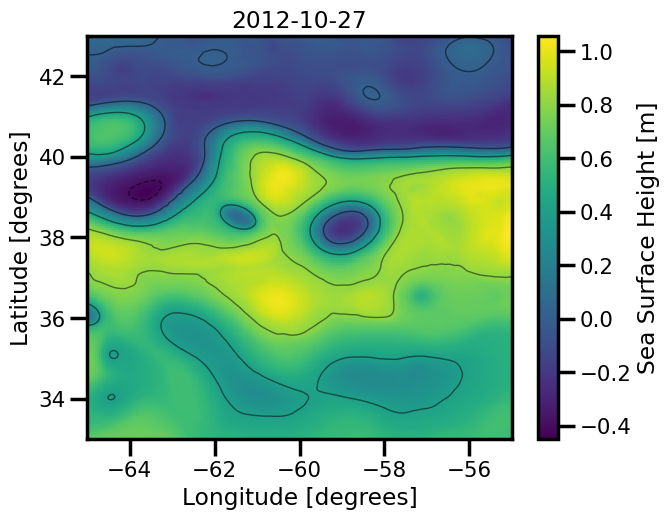

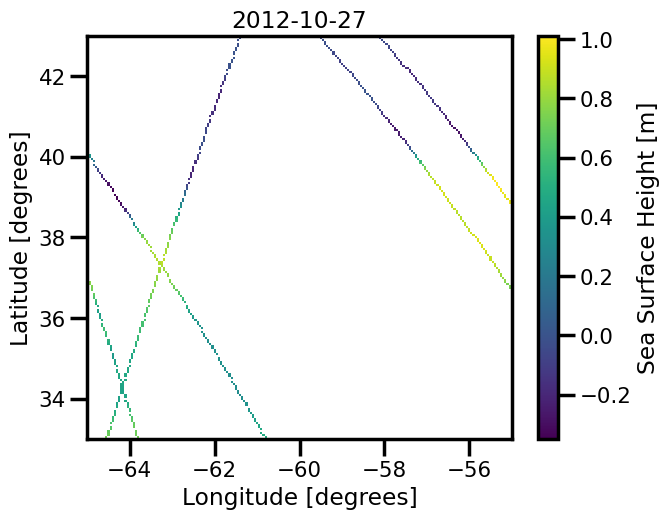

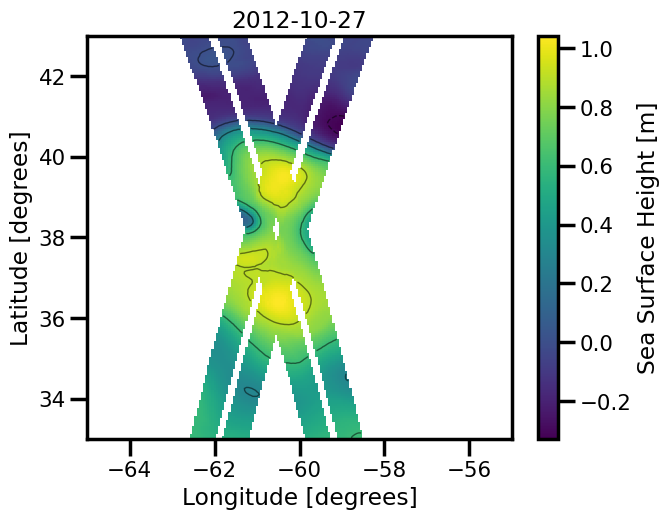

In [18]:
variable = "ssh"
xlim = [ds_natl60[variable].lon.min(), ds_natl60[variable].lon.max()]
ylim = [ds_natl60[variable].lat.min(), ds_natl60[variable].lat.max()]

def pipe_fn(ds):
    ds = correct_ssh_labels(ds)
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nemo_ssh.png")

# SWOT Data
fig, ax = plot_ssh_map(ds_nadir4.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nadir4_ssh.png")

# NADIR Data
fig, ax = plot_ssh_map(ds_swot1.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_swot1_ssh.png")

## Sea Surface Anomaly (SLA)

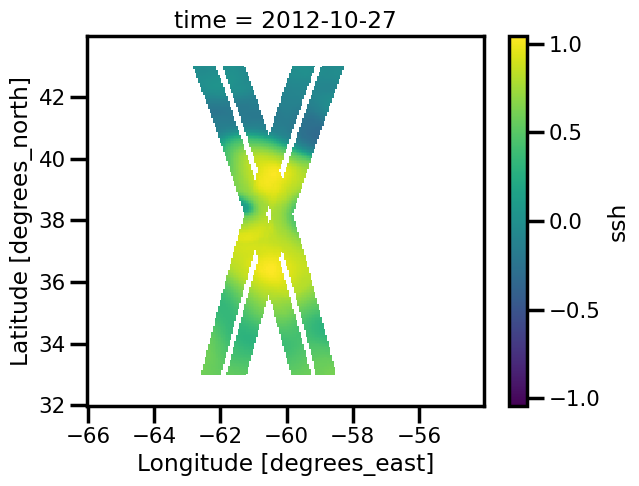

In [32]:
# ds_nadir4.ssh.isel(time=12).plot(cmap="viridis")
ds_swot1.ssh.isel(time=5).plot(cmap="viridis")

## Variables

In [19]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet

4DVarNet  DUACS   leaderboard.csv  NerF  results.csv	   results_nerf.csv
BFNQG	  DYMOST  MIOST		   OI	 results_demo.csv
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc
2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadirswot_GF_GF.nc


In [20]:
%%writefile configs/results.yaml

domain:
  lat: {_target_: "builtins.slice", _args_: [32., 44.]}
  lon: {_target_: "builtins.slice", _args_: [-66., -54.]}
  time: {_target_: "builtins.slice", _args_: ["2012-10-22", "2012-12-02"]}

registry: ../sla-data-registry
geoval: "oceanbench._src.geoprocessing.validation"

select:
    _target_: "xarray.Dataset.sel"
    _partial_: True
    indexers: "${domain}"
    
    
# DUACS
DUACS_NADIR:
    name: "duacs"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/DUACS/2020a_SSH_mapping_NATL60_DUACS_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
            
# MIOST - nadir4
MIOST_NADIR:
    name: "miost"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/MIOST/2020a_SSH_mapping_NATL60_MIOST_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
# BFNQG - nadir4
BFNQG_NADIR:
    name: "bfnqg"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/BFNQG/2020a_SSH_mapping_NATL60_BFN_Steady_State_QG1L_en_j1_tpn_g2.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"gssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}
            
            
# BFNQG - nadir4
FourDVARNET_NADIR:
    name: "4dvarnet"
    experiment: "nadir4"
    variable: "gssh"
    data:
        _target_: "oceanbench._src.data.pipe"
        inp: "/gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/results/4DVarNet/2020a_SSH_mapping_NATL60_4DVarNet_v2022_nadir_GF_GF.nc"
        fns:
            - {_target_: "xarray.open_dataset", decode_times: True, _partial_: True}
            - {_target_: "xarray.Dataset.rename", name_dict: {"ssh": "ssh"}, _partial_: True}
            # VALIDATE COORDINATES
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_latlon", _partial_: True}
            - {_target_: "oceanbench._src.geoprocessing.validation.validate_time", _partial_: True}
            # SELECT REGION
            - "${select}"
            - {_target_: "xarray.Dataset.sortby", variables: "time", _partial_: True}


Overwriting configs/results.yaml


In [72]:
# load config
results_config = OmegaConf.load(f'./configs/results.yaml')

# instantiate
ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
ds_bfnqg = hydra.utils.instantiate(results_config.BFNQG_NADIR.data).compute()
ds_4dvarnet = hydra.utils.instantiate(results_config.FourDVARNET_NADIR.data).compute()
# ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
# ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
# ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()

### Post Processing

* Regrid
* Fill Nans
* Calculate Variables

In [73]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid
from oceanbench._src.geoprocessing.interpolate import fillnan_gauss_seidel
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units
import pint_xarray

def calculate_anomaly(ds, variable="ssh", dim=["lat", "lon"]):
    ds[f"{variable}_anomaly"] = ds[variable] - ds[variable].mean(dim=dim)
    return ds

def calculate_physical_variables(ds, ds_reference=None):
    
    ds = ds.copy()
    
#     ds = ds.pint.quantify({"ssh": units.meter,
#                            "lon": units.degrees,
#                            "lat": units.degrees
#                           })
    
    # calculate variables
    ds["ssh"] *= units.meters
    ds["lon"]  = ds.lon * units.degrees
    ds["lat"] = ds.lat * units.degrees
    if ds_reference is not None:
        ds_reference["ssh"] *= units.meter

    if ds_reference is not None:
        mean = ds_reference["ssh"].mean(dim=["lat", "lon"])
    else:
        mean = ds["ssh"].mean(dim=["lat", "lon"])

    
    ds[f"sla"] = ds["ssh"] - mean
    
    ds = geocalc.streamfunction(ds, "ssh")
    ds = geocalc.geostrophic_velocities(ds, variable="psi")
    ds = geocalc.kinetic_energy(ds, variables=["u", "v"])
    ds = geocalc.divergence(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, "div")
    ds = geocalc.relative_vorticity(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, "vort_r")
    ds = geocalc.strain_magnitude(ds, variables=["u", "v"])
    ds = geocalc.coriolis_normalized(ds, variable="strain")
    
    return ds

def postprocess_fn(ds, ds_reference):
    
    # resample
    ds = ds.resample(time="1D").mean()

    # regrid
    ds = grid_to_regular_grid(
        src_grid_ds=ds.pint.dequantify(),
        tgt_grid_ds=ds_reference.pint.dequantify(), keep_attrs=False
    )
    
    # fill nans
    ds = fillnan_gauss_seidel(ds, variable="ssh")
    
    ds = calculate_physical_variables(ds.pint.dequantify(), ds_reference.pint.dequantify())
    
    return ds

In [74]:
# ds_duacs_ = calculate_physical_variables(ds_duacs.copy().pint.dequantify(), None)

In [75]:
%%time

ds_natl60_ = postprocess_fn(ds_natl60.pint.dequantify(), ds_natl60.pint.dequantify())
ds_duacs = postprocess_fn(ds_duacs.pint.dequantify(), ds_natl60.pint.dequantify())
ds_miost = postprocess_fn(ds_miost.pint.dequantify(), ds_natl60.pint.dequantify())
ds_bfnqg = postprocess_fn(ds_bfnqg.pint.dequantify(), ds_natl60.pint.dequantify())
ds_4dvarnet = postprocess_fn(ds_4dvarnet.pint.dequantify(), ds_natl60.pint.dequantify())

CPU times: user 14.3 s, sys: 271 ms, total: 14.5 s
Wall time: 11.1 s


## Sea Level Anomaly (SLA)

In [84]:
def correct_sla_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["sla"].attrs["units"] = "m"
    ds["sla"].attrs["standard_name"] = "sea_level_anomaly"
    ds["sla"].attrs["long_name"] = "Sea Level Anomaly"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

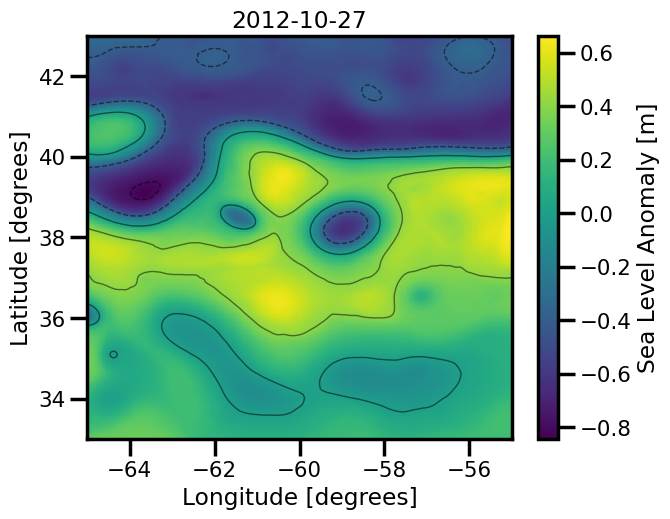

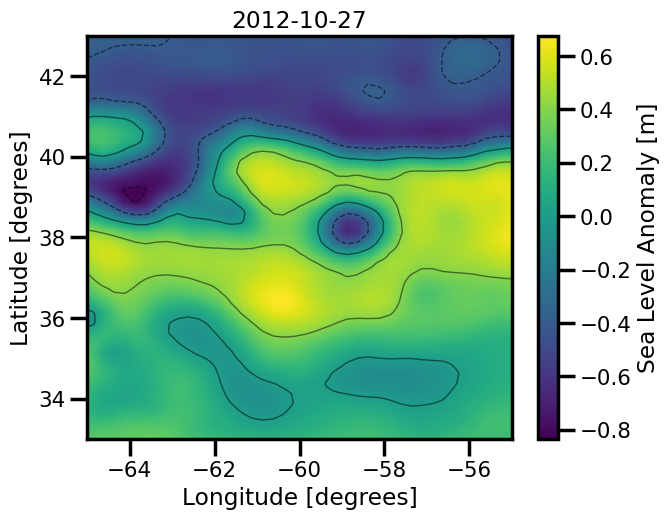

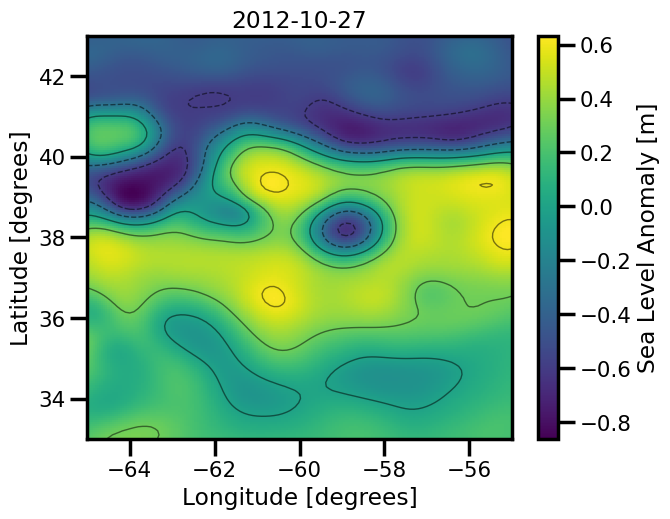

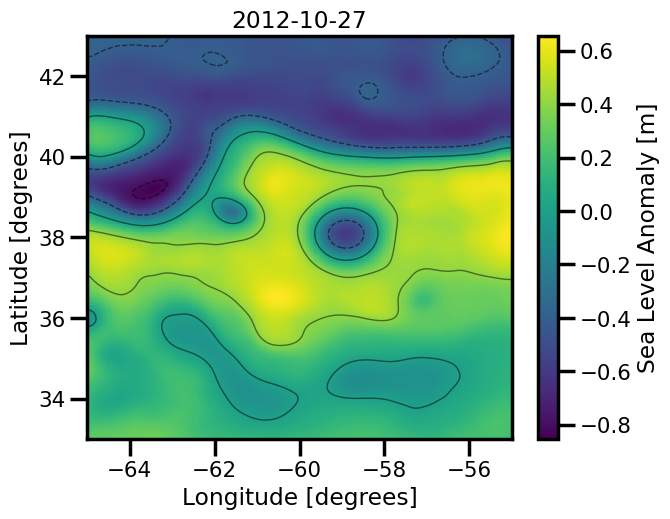

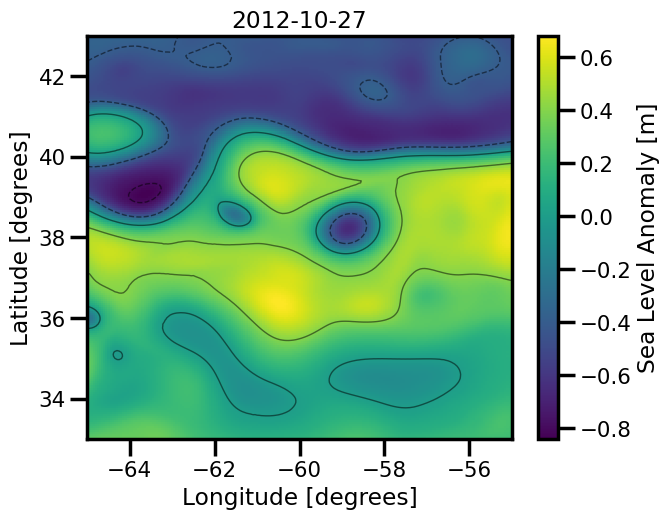

In [91]:
variable = "sla"
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]

def pipe_fn(ds):
    ds = correct_sla_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_nemo_sla.png")

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_duacs_sla.png")

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_miost_sla.png")

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_bfnqg_sla.png")

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap="viridis", xlim=xlim, ylim=ylim)
fig.savefig("./figures/maps/dc20a_4dvarnet_sla.png")


## Kinetic Energy

In [98]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ke"].attrs["units"] = r"m$^{2}$s$^{-2}$"
    ds["ke"].attrs["standard_name"] = "kinetic_energy"
    ds["ke"].attrs["long_name"] = "Kinetic Energy"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

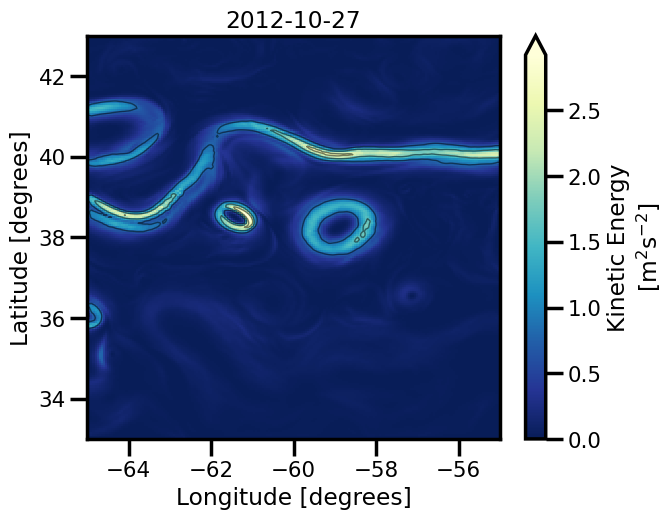

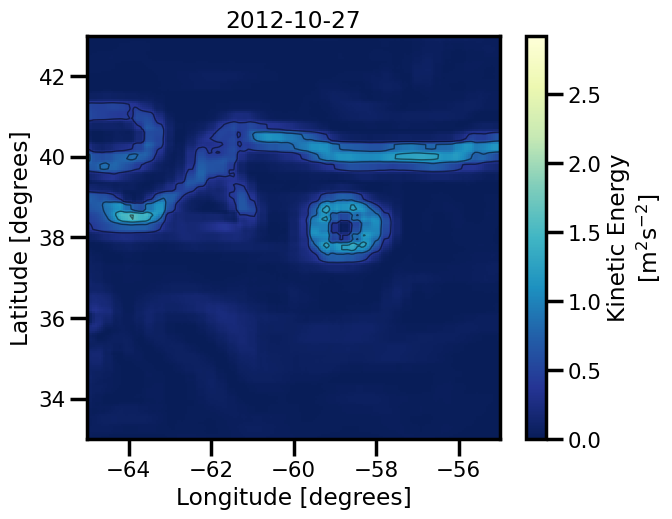

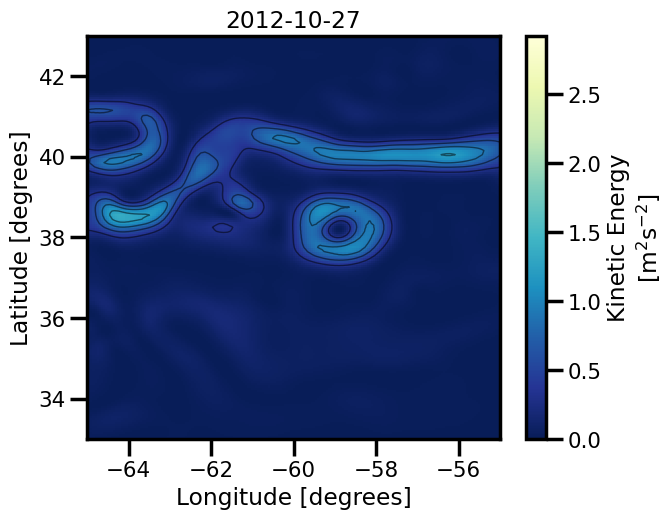

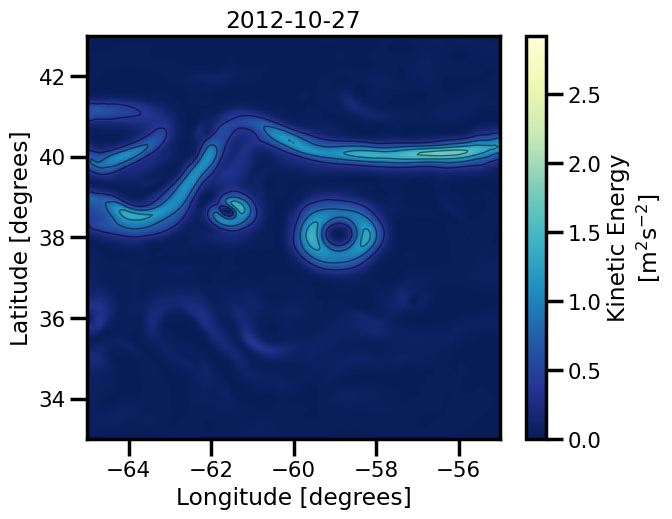

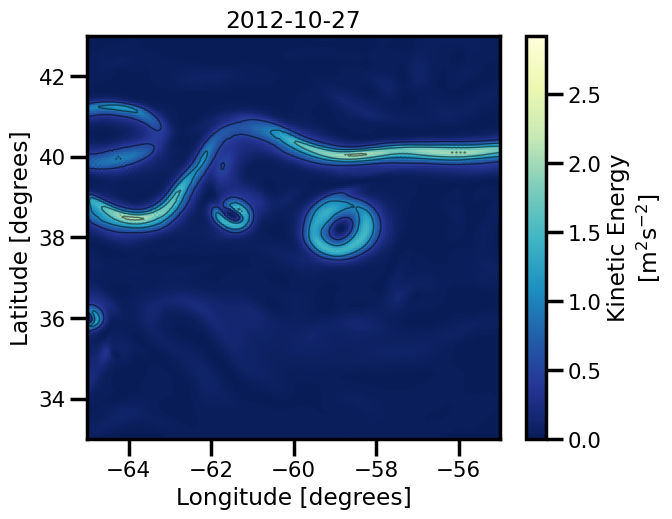

In [105]:
variable = "ke"
cmap = "YlGnBu_r"
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = 0.0 * ds_natl60_[variable].pint.dequantify().min()
vmax = 0.7 * ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_miost_{variable}.png")

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")


## Relative Vorticity

In [108]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["vort_r"].attrs["units"] = "" #r"m$^{2}$s$^{-2}$"
    ds["vort_r"].attrs["standard_name"] = "relative_vorticity"
    ds["vort_r"].attrs["long_name"] = "Relative Vorticity"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

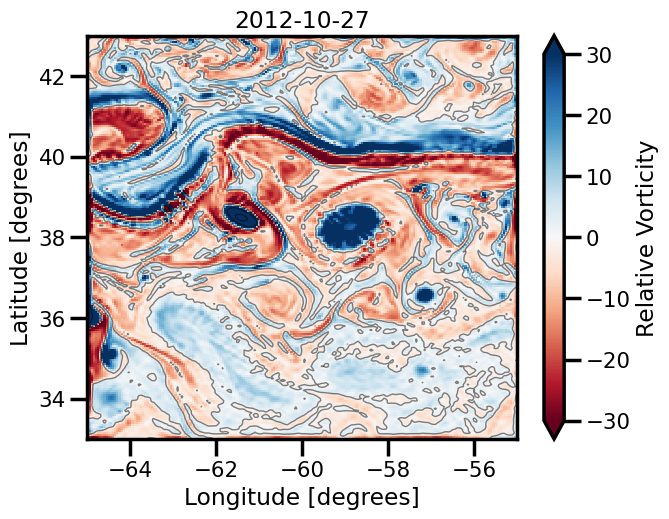

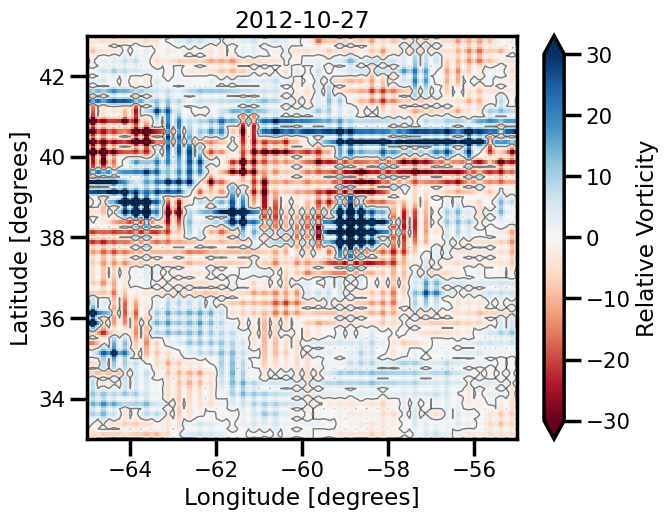

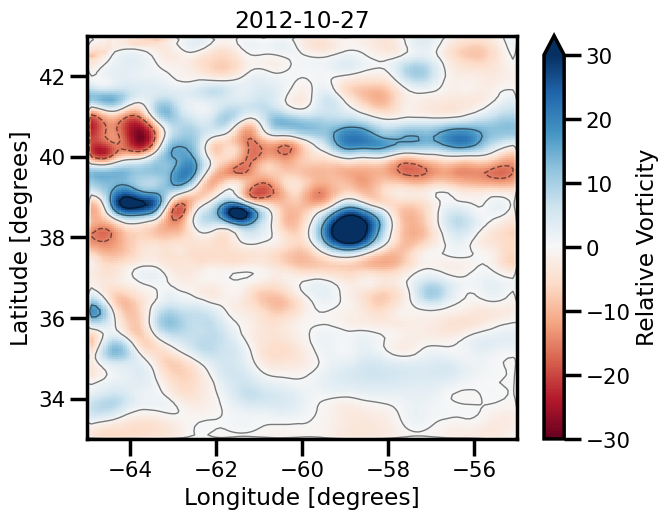

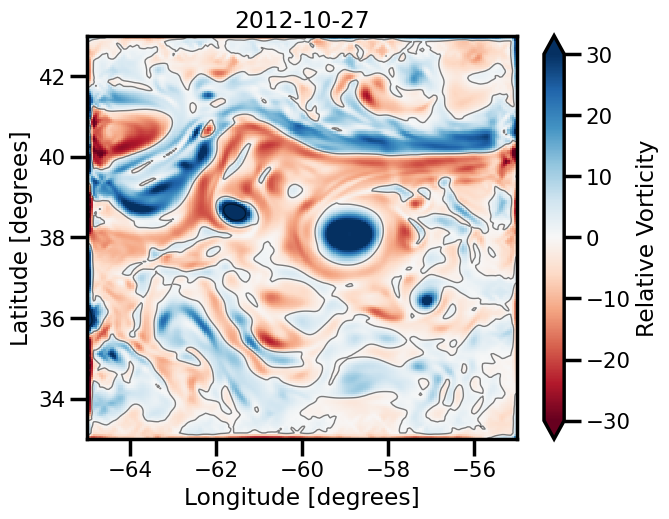

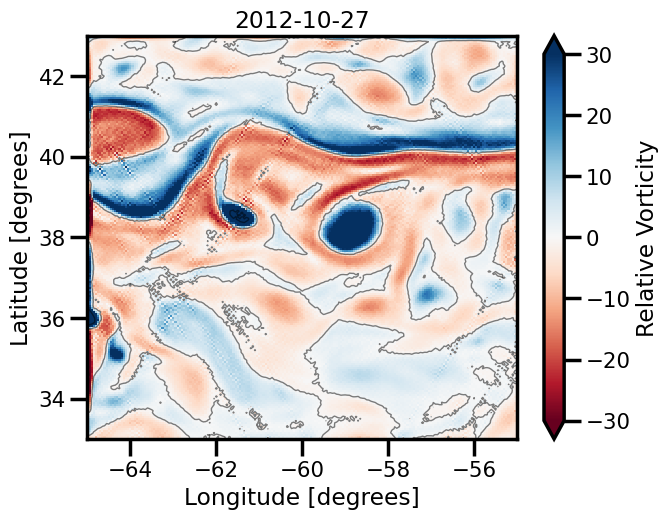

In [112]:
variable = "vort_r"
cmap = "RdBu"
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = -30 #ds_natl60_[variable].pint.dequantify().min()
vmax = 30 #ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_miost_{variable}.png")

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")


## Strain

In [108]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["strain"].attrs["units"] = "" #r"m$^{2}$s$^{-2}$"
    ds["strain"].attrs["standard_name"] = "strain"
    ds["strain"].attrs["long_name"] = "Strain"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

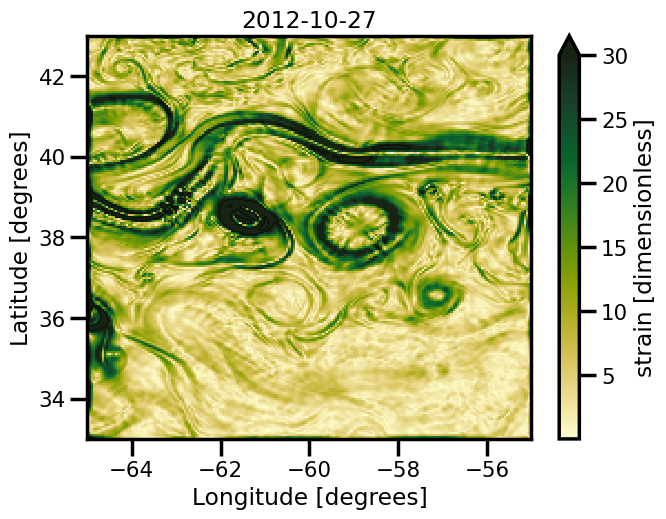

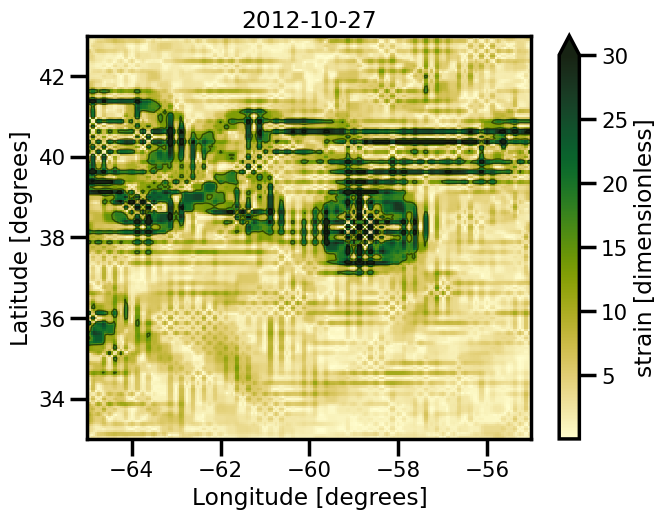

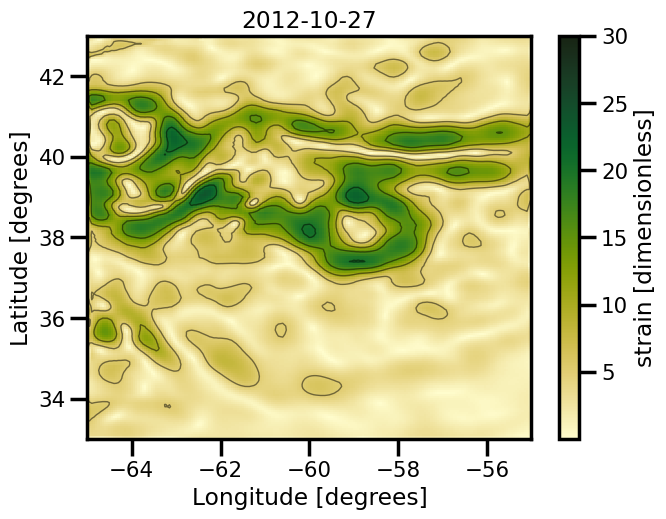

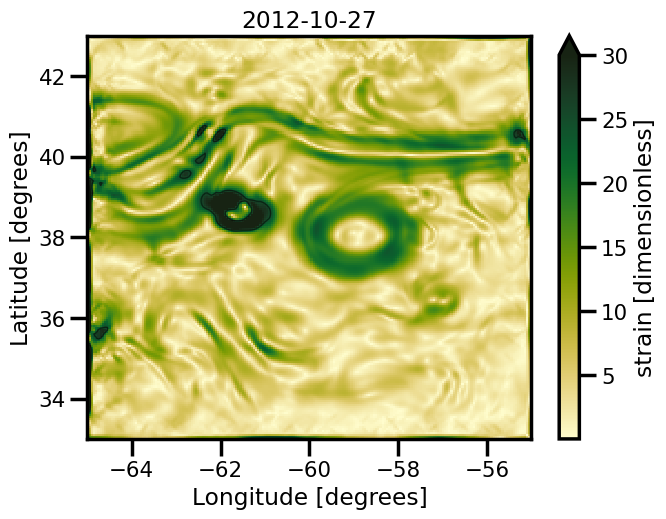

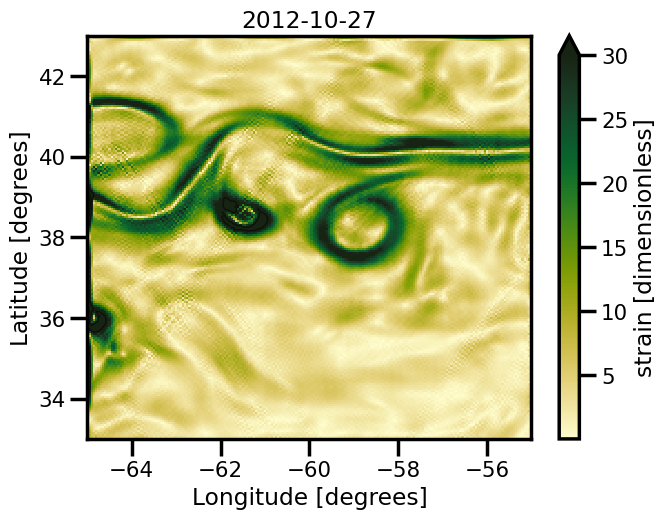

In [115]:
import cmocean as cmo
variable = "strain"
# itime = "2012-10-27"

# robust = True

variable = "strain"
cmap = cmo.cm.speed
cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
xlim = [ds_natl60_[variable].lon.min(), ds_natl60_[variable].lon.max()]
ylim = [ds_natl60_[variable].lat.min(), ds_natl60_[variable].lat.max()]
vmin = ds_natl60_[variable].pint.dequantify().min()
vmax = 30 # ds_natl60_[variable].pint.dequantify().max()

def pipe_fn(ds):
    ds = correct_labels(ds.pint.dequantify())
    ds = ds.isel(time=5)
    return ds
    

# NEMO Simulation
fig, ax = plot_ssh_map(ds_natl60_.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_nemo_{variable}.png")

# DUACS
fig, ax = plot_ssh_map(ds_duacs.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_duacs_{variable}.png")

# MIOST
fig, ax = plot_ssh_map(ds_miost.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_miost_{variable}.png")

# BFNQG
fig, ax = plot_ssh_map(ds_bfnqg.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_bfnqg_{variable}.png")

# 4DVarNet
fig, ax = plot_ssh_map(ds_4dvarnet.pipe(pipe_fn), variable=variable, cmap=cmap, xlim=xlim, ylim=ylim, vmin=vmin, vmax=vmax)
fig.savefig(f"./figures/maps/dc20a_4dvarnet_{variable}.png")


### Preprocess Chain

In [20]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 1min 4s, sys: 25 ms, total: 1min 4s
Wall time: 3.03 s


## Physical Variables

In [21]:
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [22]:
def calculate_anomaly(ds, variable="ssh", dim=["lat", "lon"]):
    ds[f"{variable}_anomaly"] = ds[variable] - ds[variable].mean(dim=dim)
    return ds

In [23]:
def calculate_physical_quantities(da):
    # da = da.pint.quantify(
    #     {
    #         "ssh": "meter",
    #         "lon": "degrees_east",
    #         "lat": "degrees_north",
    #         "time": "seconds",
    #     }
    # )
    da["ssh"] *= units.meters
    da["lon"] = da.lon * units.degrees
    da["lat"] = da.lat * units.degrees
    da = calculate_anomaly(da, variable="ssh", dim=["lat", "lon"])
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [12]:
from oceanbench._src.geoprocessing.interpolate import fillnan_gauss_seidel

In [ ]:
fillnan_gauss_seidel()

In [8]:
nadir4_config = OmegaConf.load(f'./configs/natl60_obs.yaml')
ds_nadir4 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_NADIR4.data).compute()
ds_swot1nadir5 = hydra.utils.instantiate(nadir4_config.ALONGTRACK_SWOT1NADIR5.data).compute()
ds_swot1nadir5

<xarray.Dataset>
Dimensions:  (time: 1003548)
Coordinates:
    lon      (time) float64 -55.03 -55.06 -55.1 -55.13 ... -59.01 -59.03 -59.05
    lat      (time) float64 39.58 39.53 39.47 39.42 ... 42.81 42.87 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22T11:16:43.687588 ... 2012-12-02T...
Data variables:
    ssh      (time) float64 0.9958 1.014 1.027 1.032 ... -0.112 -0.1122 -0.1118
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:39:50Z
    date_modified:             2018-10-12T12:39:50Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

## Regrdding: AlongTrack -> Uniform Grid

In [9]:
from oceanbench._src.geoprocessing.gridding import grid_to_regular_grid, coord_based_to_grid


In [10]:
%%time

ds_nadir4 = coord_based_to_grid(
    coord_based_ds=ds_nadir4,
    target_grid_ds=ds_natl60.pint.dequantify(), 
)
ds_swot1nadir5 = coord_based_to_grid(
    coord_based_ds=ds_swot1nadir5,
    target_grid_ds=ds_natl60.pint.dequantify(), 
)

CPU times: user 3.44 s, sys: 217 ms, total: 3.66 s
Wall time: 3.68 s


#### AlongTrack -> Uniform Grid

In [13]:
# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_natl60 = hydra.utils.instantiate(psd_config.fill_nans)(ds_natl60.pint.dequantify())

In [14]:
def correct_labels(ds):
    
    ds["lon"].attrs["units"] = "degrees"
    ds["lat"].attrs["units"] = "degrees"
    ds["ssh"].attrs["units"] = "m"
    ds["ssh"].attrs["standard_name"] = "sea_surface_height"
    ds["ssh"].attrs["long_name"] = "Sea Surface Height"
    ds["lon"].attrs["standard_name"] = "longitude"
    ds["lat"].attrs["standard_name"] = "latitude"
    ds["lat"].attrs["long_name"] = "Latitude"
    ds["lon"].attrs["long_name"] = "Longitude"
    
    return ds
    

In [15]:
def plot_obs(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    
    X, Y = np.meshgrid(ds[variable].lon, ds[variable].lat, indexing="ij")
    
    xlabel = f"{ds.lon.attrs['long_name']} [{ds.lon.attrs['units']}]"
    ylabel = f"{ds.lat.attrs['long_name']} [{ds.lat.attrs['units']}]"
    
    pts = ax.scatter(
        X, Y, c=np.ma.masked_invalid(ds[variable]).T, 
        marker="s",
        s=0.25,
        vmin=kwargs.pop("vmin", None), 
        vmax=kwargs.pop("vmax", None))
    ax.set(
        xlim=kwargs.pop("xlim", None),
        ylim=kwargs.pop("ylim", None),
        xlabel=xlabel,
        ylabel=ylabel,
    )
    name = ds[variable].attrs["long_name"]
    unit = ds[variable].attrs["units"]
    label = f"{name} [{unit}]"
    plt.colorbar(pts, cmap=kwargs.pop("cmap", "viridis"), label=label)
    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [16]:
vmin, vmax = correct_labels(ds_natl60).ssh.min().pint.dequantify(), correct_labels(ds_natl60).ssh.max().pint.dequantify()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
itime = "2012-10-27"
variable = "ssh"

# SWOT1NADIR5
fig, ax = plot_obs(correct_labels(ds_swot1nadir5).sel(time=itime).pint.dequantify(), variable, vmin=vmin, vmax=vmax, xlim=xlim, ylim=ylim, cmap="viridis")
fig.savefig(f"./figures/dc20a/maps/dc20a_ssh_swot1nadir5_{itime}.png")
plt.close()
# NADIR4
fig, ax = plot_obs(correct_labels(ds_nadir4).sel(time=itime).pint.dequantify(), variable, vmin=vmin, vmax=vmax, xlim=xlim, ylim=ylim, cmap="viridis")
fig.savefig(f"./figures/dc20a/maps/dc20a_ssh_nadir4_{itime}.png")
plt.close()

## Coarsend Versions

In [15]:
ds_natl60 = ds_natl60.coarsen({"lon": 3, "lat": 3}).mean()
ds_natl60

<xarray.Dataset>
Dimensions:  (time: 42, lat: 200, lon: 200)
Coordinates:
  * lon      (lon) float64 -64.97 -64.92 -64.87 -64.82 ... -55.12 -55.07 -55.02
  * lat      (lat) float64 33.03 33.08 33.13 33.18 ... 42.83 42.88 42.93 42.98
  * time     (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh      (time, lat, lon) float32 0.652 0.6585 0.6642 ... -0.2079 -0.2149
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

### Prediction Datasets 

In [17]:
%%time

# load config

experiment = "swot" # "nadir" # 
if experiment == "nadir":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_nadir.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_NADIR.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_NADIR.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_NADIR.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_NADIR.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_NADIR.data).compute()
elif experiment == "swot":
    # load config
    results_config = OmegaConf.load(f'./configs/results_dc20a_swot.yaml')

    # instantiate
    ds_duacs = hydra.utils.instantiate(results_config.DUACS_SWOT.data).compute()
    ds_miost = hydra.utils.instantiate(results_config.MIOST_SWOT.data).compute()
    ds_nerf_siren = hydra.utils.instantiate(results_config.NERF_SIREN_SWOT.data).compute()
    ds_nerf_ffn = hydra.utils.instantiate(results_config.NERF_FFN_SWOT.data).compute()
    ds_nerf_mlp = hydra.utils.instantiate(results_config.NERF_MLP_SWOT.data).compute()

CPU times: user 188 ms, sys: 71.7 ms, total: 259 ms
Wall time: 653 ms


In [18]:
!ls /gpfswork/rech/yrf/commun/data_challenges/dc20a_osse/staging/ml_ready/

alongtrack_nadir1.nc  gridded_nadir1.nc       gridded_swot1.nc	swot1nadir5.nc
alongtrack_nadir4.nc  gridded_nadir4.nc       nadir1.nc		swot1.nc
alongtrack_nadir5.nc  gridded_nadir5.nc       nadir4.nc		swot.nc
alongtrack_swot1.nc   gridded_swot1nadir5.nc  nadir5.nc


## Regrdding

#### Uniform Grid --> Uniform Grid

In [19]:
%%time

ds_duacs = grid_to_regular_grid(
    src_grid_ds=ds_duacs.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_miost = grid_to_regular_grid(
    src_grid_ds=ds_miost.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_siren = grid_to_regular_grid(
    src_grid_ds=ds_nerf_siren.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_ffn = grid_to_regular_grid(
    src_grid_ds=ds_nerf_ffn.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)
ds_nerf_mlp = grid_to_regular_grid(
    src_grid_ds=ds_nerf_mlp.pint.dequantify(),
    tgt_grid_ds=ds_natl60.pint.dequantify(), keep_attrs=False
)

CPU times: user 50.5 s, sys: 1.32 s, total: 51.8 s
Wall time: 52.1 s


### Preprocess Chain

In [20]:
%%time

# load config
psd_config = OmegaConf.load('./configs/metrics.yaml')

ds_duacs = hydra.utils.instantiate(psd_config.fill_nans)(ds_duacs.pint.dequantify())
ds_miost = hydra.utils.instantiate(psd_config.fill_nans)(ds_miost.pint.dequantify())
ds_nerf_siren = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = hydra.utils.instantiate(psd_config.fill_nans)(ds_nerf_mlp.pint.dequantify())


CPU times: user 1min 4s, sys: 25 ms, total: 1min 4s
Wall time: 3.03 s


## Physical Variables

In [21]:
from oceanbench._src.geoprocessing import geostrophic as geocalc
from metpy.units import units

In [22]:
def calculate_anomaly(ds, variable="ssh", dim=["lat", "lon"]):
    ds[f"{variable}_anomaly"] = ds[variable] - ds[variable].mean(dim=dim)
    return ds

In [23]:
def calculate_physical_quantities(da):
    # da = da.pint.quantify(
    #     {
    #         "ssh": "meter",
    #         "lon": "degrees_east",
    #         "lat": "degrees_north",
    #         "time": "seconds",
    #     }
    # )
    da["ssh"] *= units.meters
    da["lon"] = da.lon * units.degrees
    da["lat"] = da.lat * units.degrees
    da = calculate_anomaly(da, variable="ssh", dim=["lat", "lon"])
    da = geocalc.streamfunction(da, "ssh")
    da = geocalc.geostrophic_velocities(da, variable="psi")
    da = geocalc.kinetic_energy(da, variables=["u", "v"])
    da = geocalc.divergence(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "div")
    da = geocalc.relative_vorticity(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, "vort_r")
    da = geocalc.strain_magnitude(da, variables=["u", "v"])
    da = geocalc.coriolis_normalized(da, variable="strain")
    return da

In [24]:
ds_natl60 = calculate_physical_quantities(ds_natl60.pint.dequantify())
ds_natl60

<xarray.Dataset>
Dimensions:      (time: 42, lat: 600, lon: 600)
Coordinates:
  * lon          (lon) float64 -64.98 -64.97 -64.95 ... -55.03 -55.02 -55.0
  * lat          (lat) float64 33.02 33.03 33.05 33.07 ... 42.97 42.98 43.0
  * time         (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
Data variables:
    ssh          (time, lat, lon) float32 [m] 0.6548789 ... -0.21744703
    ssh_anomaly  (time, lat, lon) float32 [m] 0.22254914 ... -0.6304018
    psi          (time, lat, lon) float64 [m²/s] 7.16e+04 ... -2.377e+04
    u            (time, lat, lon) float64 [m/s] 0.2986 0.2905 ... 7.752e-05
    v            (time, lat, lon) float64 [m/s] 0.1618 0.1548 ... -0.1775
    ke           (time, lat, lon) float64 [m²/s²] 0.05767 0.05417 ... 0.01576
    div          (time, lat, lon) float64 [] 0.0001059 8.584e-05 ... -0.0002832
    vort_r       (time, lat, lon) float64 [] -7.259 -7.626 ... 9.834 10.59
    strain       (time, lat, lon) float64 [] 6.425 6.613 6.734 ... 5.637 6.694
Attributes:
    Info:     Horizontal grid read in regulargrid_NATL60.nc / Source field re...
    About:    Created by SOSIE interpolation environement => https://github.c...

In [25]:
%%time

ds_natl60 = calculate_physical_quantities(ds_natl60.pint.dequantify())
ds_duacs = calculate_physical_quantities(ds_duacs.pint.dequantify())
ds_miost = calculate_physical_quantities(ds_miost.pint.dequantify())
ds_nerf_siren = calculate_physical_quantities(ds_nerf_siren.pint.dequantify())
ds_nerf_ffn = calculate_physical_quantities(ds_nerf_ffn.pint.dequantify())
ds_nerf_mlp = calculate_physical_quantities(ds_nerf_mlp.pint.dequantify())

CPU times: user 32 s, sys: 19.7 s, total: 51.7 s
Wall time: 51.8 s


## Sea Surface Height

In [26]:
def plot_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", None)
    vmax=kwargs.pop("vmax", None)
    cmap=kwargs.pop("cmap", "viridis")
    loc = ticker.MaxNLocator(kwargs.pop("levels", 5))
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        levels=levels,
        alpha=0.5, linewidths=1, cmap="black",
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax
from matplotlib import ticker

def plot_ssh_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", ds[variable].min().values)
    vmax=kwargs.pop("vmax", ds[variable].max().values)
    cmap=kwargs.pop("cmap", "viridis")
    levels = kwargs.pop("levels", 5)
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    loc = ticker.MaxNLocator(levels)
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    ds[variable].plot.contour(
        ax=ax, 
        alpha=0.5, linewidths=1, cmap="black",
        levels=levels,
        linestyles=np.where(levels >= 0, "-", "--")
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

In [27]:
ds_natl60_mean = ds_natl60.mean(dim=["lat", "lon"])
ds_duacs_mean = ds_duacs.mean(dim=["lat", "lon"])
ds_miost_mean = ds_miost.mean(dim=["lat", "lon"])
ds_nerf_mlp_mean = ds_nerf_mlp.mean(dim=["lat", "lon"])
ds_nerf_ffn_mean = ds_nerf_ffn.mean(dim=["lat", "lon"])
ds_nerf_siren_mean = ds_nerf_siren.mean(dim=["lat", "lon"])

ds_natl60_var = ds_natl60.var(dim=["lat", "lon"])
ds_duacs_var = ds_duacs.var(dim=["lat", "lon"])
ds_miost_var = ds_miost.var(dim=["lat", "lon"])
ds_nerf_mlp_var = ds_nerf_mlp.var(dim=["lat", "lon"])
ds_nerf_ffn_var = ds_nerf_ffn.var(dim=["lat", "lon"])
ds_nerf_siren_var = ds_nerf_siren.var(dim=["lat", "lon"])

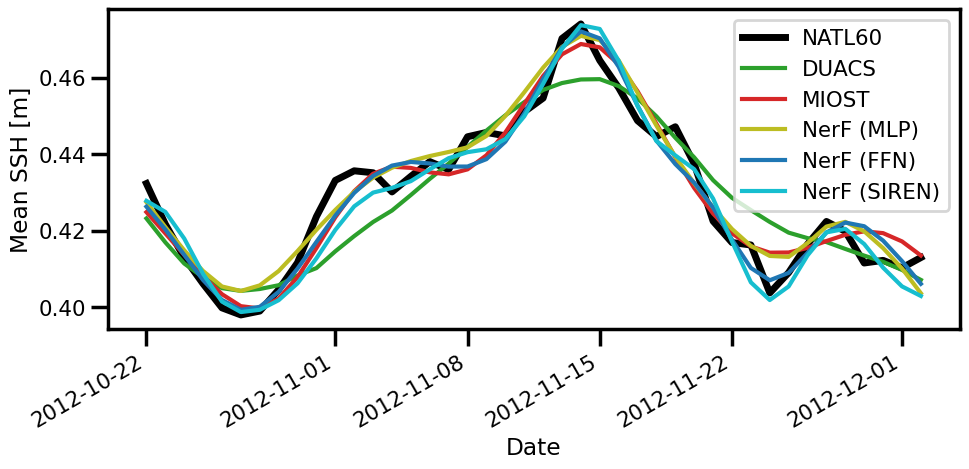

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

ds_natl60_mean.ssh.plot(ax=ax, label="NATL60", color="black", linewidth=5)
ds_duacs_mean.ssh.plot(ax=ax, label="DUACS", color="tab:green")
ds_miost_mean.ssh.plot(ax=ax, label="MIOST", color="tab:red")
ds_nerf_mlp_mean.ssh.plot(ax=ax, label="NerF (MLP)", color="tab:olive")
ds_nerf_ffn_mean.ssh.plot(ax=ax, label="NerF (FFN)", color="tab:blue")
ds_nerf_siren_mean.ssh.plot(ax=ax, label="NerF (SIREN)", color="tab:cyan")
ax.set(
    xlabel="Date", 
    ylabel="Mean SSH [m]"
)

plt.legend()
plt.tight_layout()
plt.show()

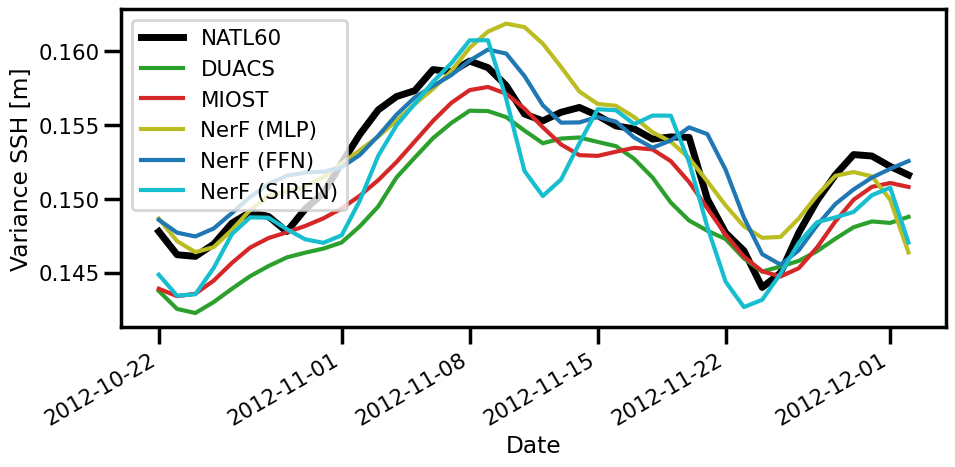

In [29]:
fig, ax = plt.subplots(figsize=(10,5))

ds_natl60_var.ssh.plot(ax=ax, label="NATL60", color="black", linewidth=5)
ds_duacs_var.ssh.plot(ax=ax, label="DUACS", color="tab:green")
ds_miost_var.ssh.plot(ax=ax, label="MIOST", color="tab:red")
ds_nerf_mlp_var.ssh.plot(ax=ax, label="NerF (MLP)", color="tab:olive")
ds_nerf_ffn_var.ssh.plot(ax=ax, label="NerF (FFN)", color="tab:blue")
ds_nerf_siren_var.ssh.plot(ax=ax, label="NerF (SIREN)", color="tab:cyan")
ax.set(
    xlabel="Date", 
    ylabel="Variance SSH [m]"
)

plt.legend()
plt.tight_layout()
plt.show()

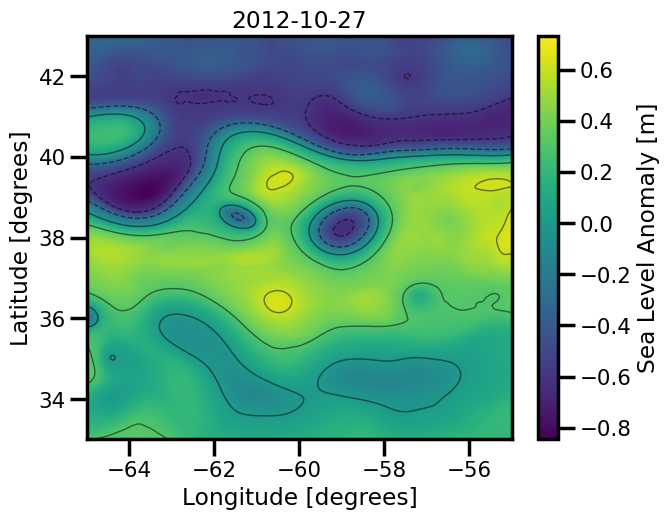

In [43]:
variable = "ssh_anomaly"
vmin = correct_labels(ds_natl60)[variable].min().pint.dequantify()
vmax = correct_labels(ds_natl60)[variable].max().pint.dequantify()
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]
itime = "2012-10-27"
cmap = "viridis"

ds_natl60[variable].attrs["long_name"] = "Sea Level Anomaly"


#NATL60
fig, ax = plot_ssh_map(
    correct_labels(ds_natl60).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Sea Level Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

In [33]:
ds_swot1nadir5["ssh"].pint.dequantify() - ds_natl60_mean.pint.dequantify()

<xarray.Dataset>
Dimensions:      (time: 42, lat: 600, lon: 600)
Coordinates:
  * time         (time) datetime64[ns] 2012-10-22 2012-10-23 ... 2012-12-02
  * lat          (lat) float64 33.02 33.03 33.05 33.07 ... 42.97 42.98 43.0
  * lon          (lon) float64 -64.98 -64.97 -64.95 ... -55.03 -55.02 -55.0
Data variables:
    ssh          (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ssh_anomaly  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    psi          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    u            (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    v            (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    ke           (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    div          (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    vort_r       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    strain       (time, lat, lon) float64 nan nan nan nan ... nan nan nan nan

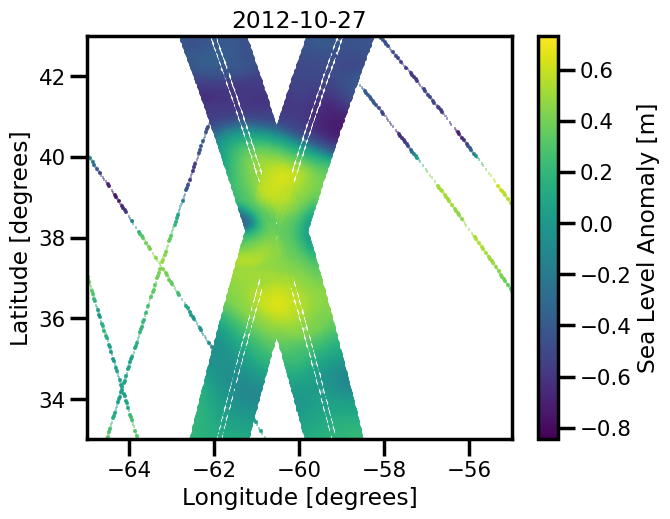

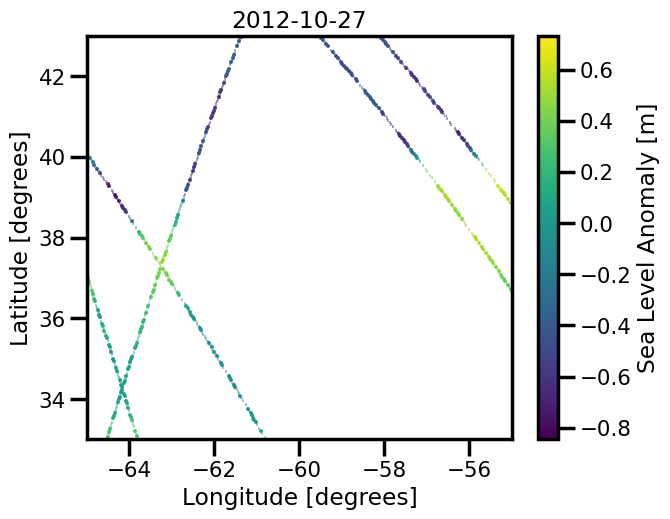

In [41]:
ds_swot1nadir5[f"ssh_anomaly"] = ds_swot1nadir5["ssh"].pint.dequantify() - ds_natl60_mean["ssh"].pint.dequantify()
ds_nadir4[f"ssh_anomaly"] = ds_nadir4["ssh"].pint.dequantify() - ds_natl60_mean["ssh"].pint.dequantify()
ds_swot1nadir5[f"ssh_anomaly"].attrs["long_name"] = "Sea Level Anomaly"
ds_swot1nadir5[f"ssh_anomaly"].attrs["units"] = "m"
ds_nadir4[f"ssh_anomaly"].attrs["long_name"] = "Sea Level Anomaly"
ds_nadir4[f"ssh_anomaly"].attrs["units"] = "m"
# SWOT1NADIR5
fig, ax = plot_obs(correct_labels(ds_swot1nadir5).sel(time=itime).pint.dequantify(), variable, vmin=vmin, vmax=vmax, xlim=xlim, ylim=ylim, cmap="viridis")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_swot1nadir5_{itime}.png")
plt.show()
# NADIR4
fig, ax = plot_obs(correct_labels(ds_nadir4).sel(time=itime).pint.dequantify(), variable, vmin=vmin, vmax=vmax, xlim=xlim, ylim=ylim, cmap="viridis")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nadir4_{itime}.png")
plt.show()

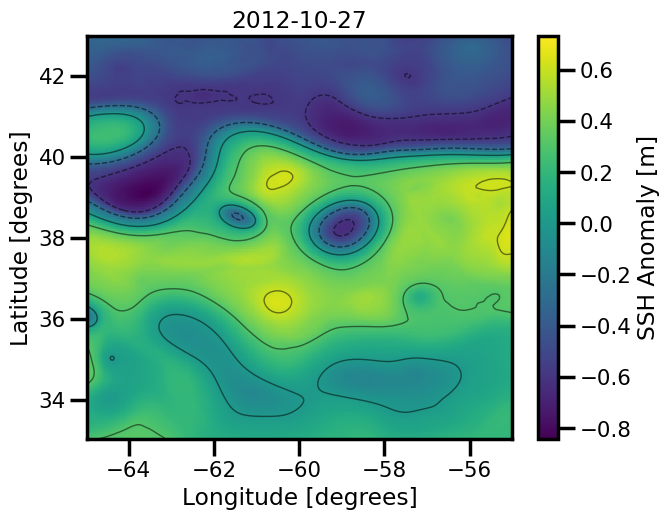

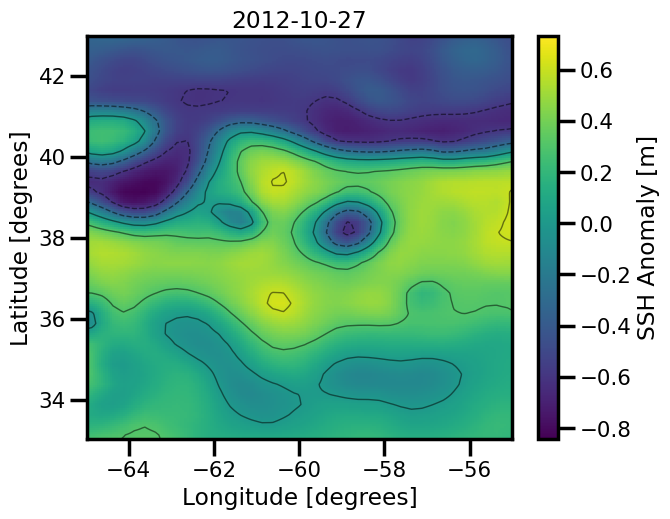

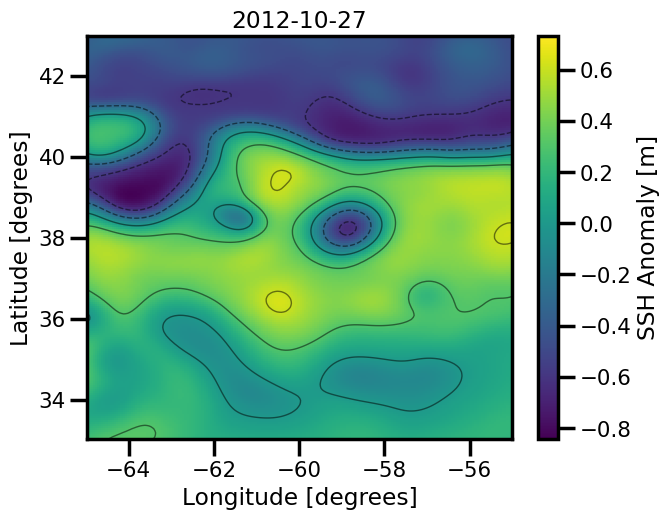

In [105]:


# DUACS
fig, ax = plot_ssh_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.show()

# MIOST
fig, ax = plot_ssh_map(
    correct_labels(ds_miost).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.show()

# NERF - MLP
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_mlp).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_ssh_map(
    correct_labels(ds_nerf_siren).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "SSH Anomaly [m]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()

## Kinetic Energy

In [70]:
def plot_ke_map(ds, variable: str="ssh", **kwargs):
    
    fig, ax = plt.subplots(figsize=(7,5.5))
    vmin=kwargs.pop("vmin", None)
    vmax=kwargs.pop("vmax", None)
    cmap=kwargs.pop("cmap", "viridis")
    # loc = ticker.MaxNLocator()
    loc = ticker.LogLocator(numticks=kwargs.pop("levels", 10))
    
    ds[variable].plot.pcolormesh(
        ax=ax, vmin=vmin, vmax=vmax, cmap=cmap,
        cbar_kwargs=kwargs.pop("cbar_kwargs", None),
        **kwargs,
    )
    
    levels = loc.tick_values(ds[variable].min().values, ds[variable].max().values)
    
    ds[variable].plot.contour(
        ax=ax, 
        levels=levels,
        alpha=0.5, linewidths=1, cmap="black",
        # vmin=vmin, vmax=vmax,
        # **kwargs
    )    
    ax.set_title(pd.to_datetime(ds.time.values).strftime('%Y-%m-%d'))
    fig.tight_layout()
    
    return fig, ax

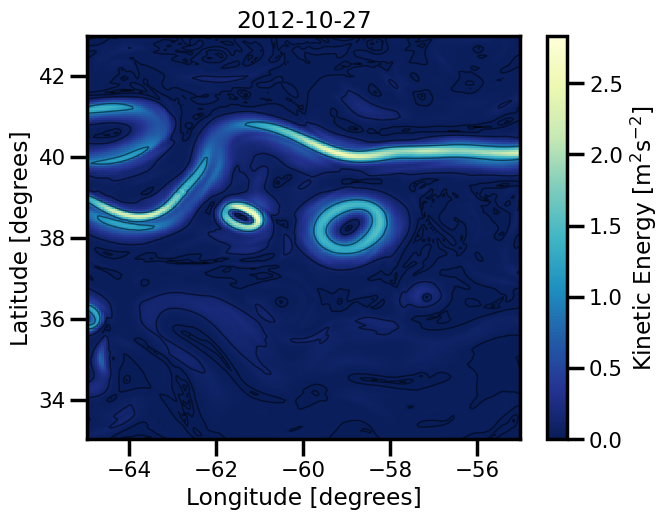

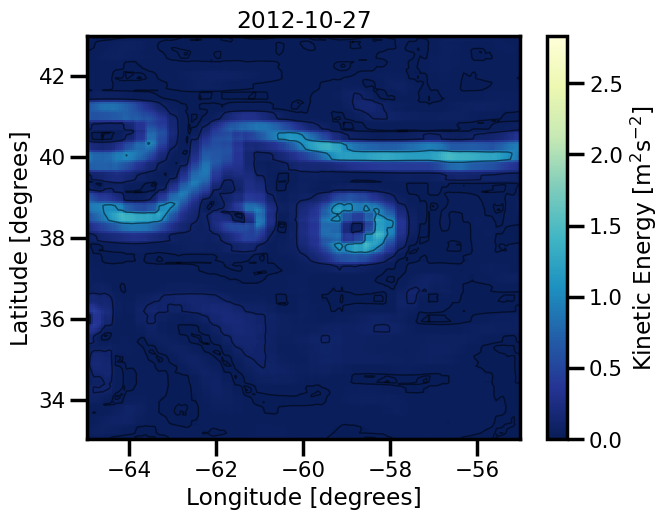

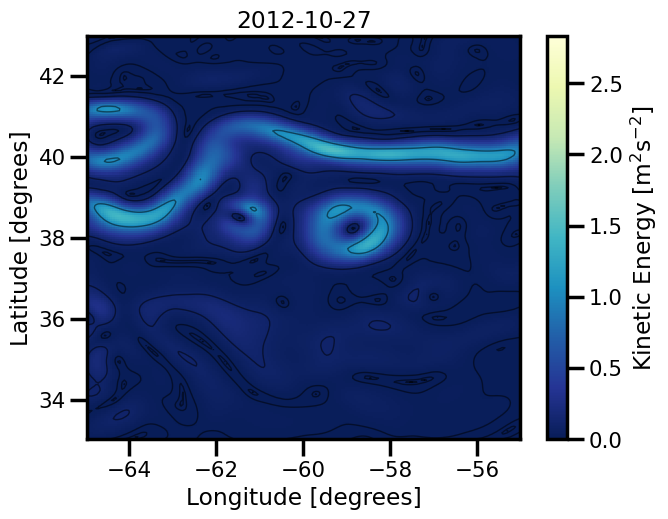

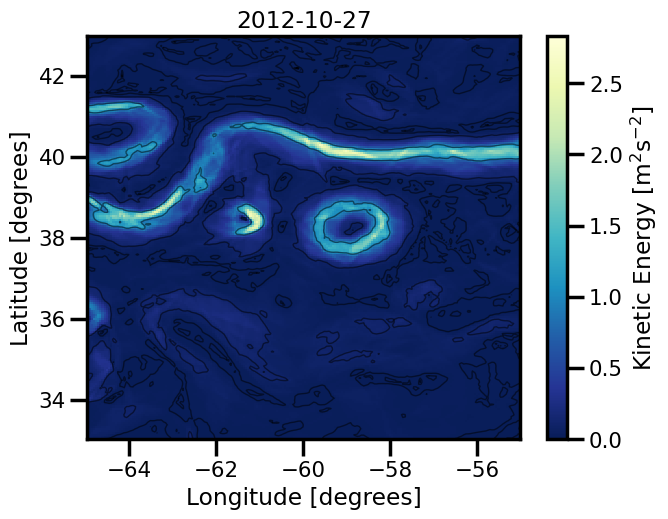

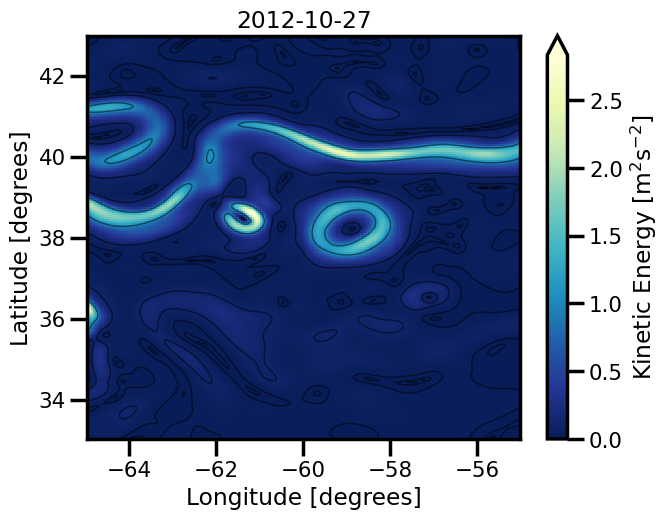

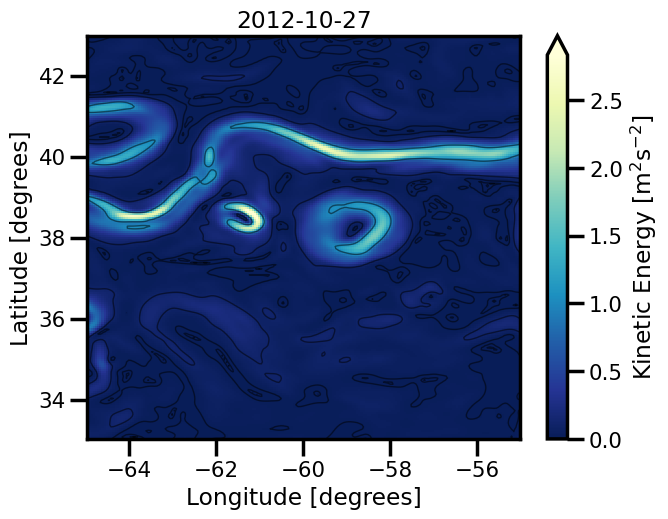

In [100]:
variable = "ke"
itime = "2012-10-27"
cmap = "YlGnBu_r"
robust = True

vmin = 0 #0.95 * ds_natl60[variable].sel(time=itime).min().pint.dequantify()#.quantile(0.05)
vmax = 1.05 * ds_natl60[variable].sel(time=itime).max().pint.dequantify()#.quantile(0.95)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]

#NATL60
fig, ax = plot_ke_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_ke_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.show()

# MIOST
fig, ax = plot_ke_map(
    ds_miost.sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.show()

# NERF - MLP
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_mlp).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.show()

# NERF - FFN
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.show()

# NERF - SIREN
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_siren).sel(time=itime), 
    variable, vmin=vmin, vmax=vmax, xlim=xlim, 
    ylim=ylim, cmap=cmap, 
    robust=False,
    cbar_kwargs={"label": "Kinetic Energy [m$^{2}$s$^{-2}$]"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.show()

## Relative Vorticity

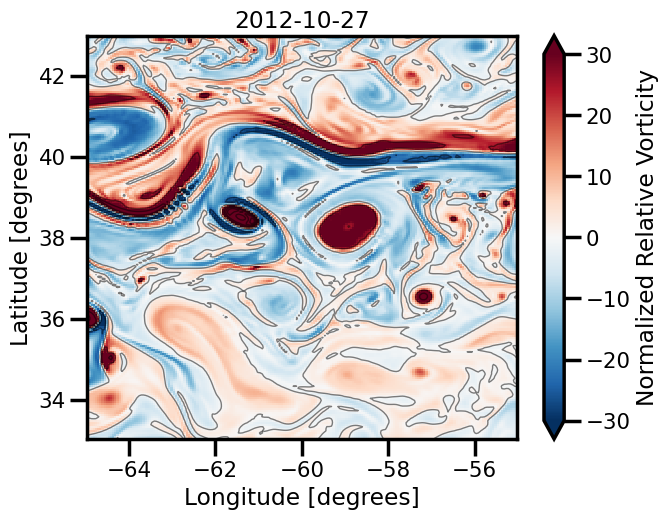

In [89]:
variable = "vort_r"
itime = "2012-10-27"
cmap = "RdBu_r"
robust = True

vmin = -30 #ds_natl60[variable].sel(time=itime).min().pint.dequantify().quantile(0.10)
vmax = 30 # ds_natl60[variable].sel(time=itime).max().pint.dequantify().quantile(0.90)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]


#NATL60
fig, ax = plot_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_map(
    correct_labels(ds_duacs).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.close()

# MIOST
fig, ax = plot_map(
    correct_labels(ds_miost).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.close()

# NERF - MLP
fig, ax = plot_map(
    correct_labels(ds_nerf_mlp).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_map(
    correct_labels(ds_nerf_siren).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=10,
    cbar_kwargs={"label": "Normalized Relative Vorticity"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()

## Strain

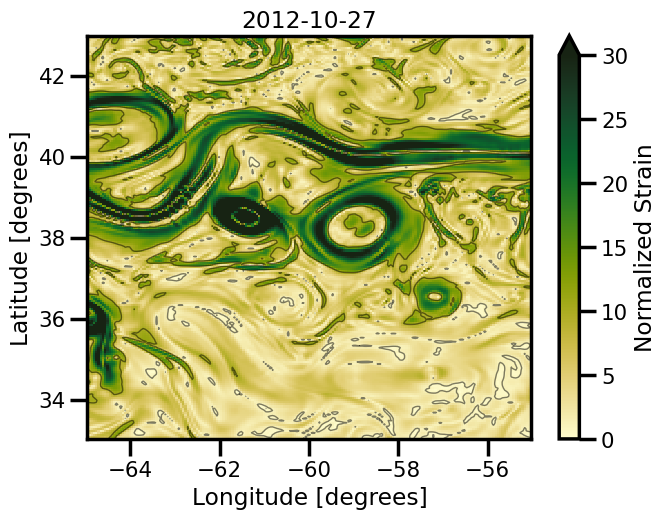

In [99]:
import cmocean as cmo
variable = "strain"
itime = "2012-10-27"
cmap = cmo.cm.speed
robust = True

vmin = 0#ds_natl60[variable].sel(time=itime).min().pint.dequantify().quantile(0.10)
vmax = 30 #ds_natl60[variable].sel(time=itime).max().pint.dequantify().quantile(0.90)
xlim = [ds_natl60.lon.min().values, ds_natl60.lon.max().values]
ylim = [ds_natl60.lat.min().values, ds_natl60.lat.max().values]



#NATL60
fig, ax = plot_ke_map(
    ds_natl60.sel(time=itime).pint.dequantify(), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_natl60_{experiment}_{itime}.png")
plt.show()

# DUACS
fig, ax = plot_ke_map(
    correct_labels(ds_duacs).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_duacs_{experiment}_{itime}.png")
plt.close()

# MIOST
fig, ax = plot_ke_map(
    correct_labels(ds_miost).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_miost_{experiment}_{itime}.png")
plt.close()

# NERF - MLP
fig, ax = plot_ke_map(
    correct_labels(ds_nerf_mlp).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_mlp_{experiment}_{itime}.png")
plt.close()

# NERF - FFN
fig, ax = plot_map(
    correct_labels(ds_nerf_ffn).sel(time=itime), 
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_ffn_{experiment}_{itime}.png")
plt.close()

# NERF - SIREN
fig, ax = plot_map(
    correct_labels(ds_nerf_siren).sel(time=itime),
    variable, 
    vmin=vmin, vmax=vmax, 
    xlim=xlim, ylim=ylim, cmap=cmap, 
    robust=False,
    levels=5,
    cbar_kwargs={"label": "Normalized Strain"}
)
ax.set(xlabel="Longitude [degrees]", ylabel="Latitude [degrees]")
fig.savefig(f"./figures/dc20a/maps/dc20a_{variable}_nerf_siren_{experiment}_{itime}.png")
plt.close()